In [2]:
#dependencies and point to where the data will live
import json
import pandas as pd
import numpy as np
import re

file_dir = "C://Users/ryang/Documents/Bootcamp/Module8-ETL/movies-etl/Data/"

In [3]:
# load json data
with open(f'{file_dir}wikipedia-movies.json', mode = 'r') as file:
    wiki_movies_raw = json.load(file)

In [91]:
#load kaggle data
kaggle_metadata = pd.read_csv(f'{file_dir}movies_metadata.csv', low_memory=False)
ratings = pd.read_csv(f'{file_dir}ratings.csv')

# Cleaning Wikipedia data

In [5]:
#check out wiki data

wiki_movies_df = pd.DataFrame(wiki_movies_raw)

len(wiki_movies_df.columns)

193

In [6]:
#filter out movies without a director or imdb link and add tv

wiki_movies = [movie for movie in wiki_movies_raw
                if ('Director' in movie or 'Directed by' in movie)
                and 'imdb_link' in movie
                and 'No. of episodes' not in movie]

len(wiki_movies)

7076

In [7]:
#starting the clean movie function

def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    
    #take all alternative titles, collapse to one column
    alt_titles = {}

    #loop through alt title names
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune–Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:

        #if any alt titles exist, add them to a dictionary, put that dictionary in movie list
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
        
        if len(alt_titles) > 0:
            movie['alt_titles'] = alt_titles
    
    #define a function to condense similar columns into one
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)

    #run above function on similar columns
    #see ColumnChanges.xlsx for work on deciding these columns
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Original language(s)', 'Language')
    change_column_name('Original release', 'Release date')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Voices of', 'Starring')
    change_column_name('Written by', 'Writer(s)')


    return movie

In [8]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]

len(clean_movies)

7076

In [9]:
wiki_movies_df = pd.DataFrame(clean_movies)

sorted(wiki_movies_df.columns.to_list())

['Animation by',
 'Audio format',
 'Based on',
 'Box office',
 'Budget',
 'Cinematography',
 'Color process',
 'Composer(s)',
 'Country',
 'Created by',
 'Director',
 'Distributor',
 'Editor(s)',
 'Executive producer(s)',
 'Followed by',
 'Genre',
 'Label',
 'Language',
 'Narrated by',
 'Original network',
 'Picture format',
 'Preceded by',
 'Producer(s)',
 'Production company(s)',
 'Production location(s)',
 'Recorded',
 'Release date',
 'Running time',
 'Starring',
 'Suggested by',
 'Theme music composer',
 'Venue',
 'Writer(s)',
 'alt_titles',
 'imdb_link',
 'title',
 'url',
 'year']

In [10]:
#extract imdb id from the link, for merging with kaggle data

wiki_movies_df["imdb_id"] = wiki_movies_df["imdb_link"].str.extract(r'(tt\d{7})')
print(f"Length of wiki movies df before dropping duplicates: {len(wiki_movies_df)}")

wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)

print(f"Length of wiki movies df after dropping duplicates: {len(wiki_movies_df)}")

Length of wiki movies df before dropping duplicates: 7076
Length of wiki movies df after dropping duplicates: 7033


In [11]:
null_counts = [[column, wiki_movies_df[column].isnull().sum()] for column in wiki_movies_df.columns]

for item in null_counts:
    print(item)

['url', 0]
['year', 0]
['imdb_link', 0]
['title', 1]
['Based on', 4852]
['Starring', 182]
['Narrated by', 6752]
['Cinematography', 691]
['Release date', 32]
['Running time', 139]
['Country', 236]
['Language', 86]
['Budget', 2295]
['Box office', 1548]
['Director', 0]
['Distributor', 357]
['Editor(s)', 548]
['Composer(s)', 585]
['Producer(s)', 202]
['Production company(s)', 1678]
['Writer(s)', 199]
['Genre', 6923]
['Theme music composer', 6966]
['Original network', 6908]
['Executive producer(s)', 6936]
['Production location(s)', 6986]
['Picture format', 6969]
['Audio format', 6972]
['Followed by', 7024]
['Created by', 7023]
['Preceded by', 7023]
['Suggested by', 7032]
['alt_titles', 7012]
['Recorded', 7031]
['Venue', 7032]
['Label', 7031]
['Animation by', 7031]
['Color process', 7032]
['imdb_id', 0]


In [12]:
# a lot of columns have >6000 null points
# just keep columns that are > 90% data filled

wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

In [13]:
len(wiki_movies_df)

7033

In [14]:
#inspecting columns to change datatypes
wiki_movies_df.dtypes

url                      object
year                      int64
imdb_link                object
title                    object
Based on                 object
Starring                 object
Cinematography           object
Release date             object
Running time             object
Country                  object
Language                 object
Budget                   object
Box office               object
Director                 object
Distributor              object
Editor(s)                object
Composer(s)              object
Producer(s)              object
Production company(s)    object
Writer(s)                object
imdb_id                  object
dtype: object

In [15]:
box_office = wiki_movies_df['Box office'].dropna()

box_office.tail(20)

7054     $72.7 million
7056       $43 million
7057          $756,473
7058     $68.6 million
7059     $46.6 million
7060      $9.5 million
7061    $375.5 million
7062     $83.7 million
7063    $172.5 million
7064     $20.6 million
7065    $349.5 million
7066    $1.148 billion
7067      $468 million
7068     $12.9 million
7069     $72.3 million
7070     $19.4 million
7071     $41.9 million
7072     $76.1 million
7073     $38.4 million
7074      $5.5 million
Name: Box office, dtype: object

In [16]:
#find out what entries aren't strings
box_office[box_office.map(lambda x: type(x) != str)]

#convert lists
box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)

box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [17]:
#building regex strings to parse box office data


form_one = r"\$\s*\d+\.?\d*\s*[mb]ill?i?on"

box_office.str.contains(form_one, flags=re.IGNORECASE, na=False).sum()

form_two = r"\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illi?on)"

box_office.str.contains(form_two, flags=re.IGNORECASE, na=False).sum()



1559

In [18]:
matches_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE, na=False)
matches_form_two = box_office.str.contains(form_two, flags=re.IGNORECASE, na=False)

In [19]:
len(box_office[~matches_form_one & ~matches_form_two])

19

In [20]:
#make a function to turn our dollar amount strings to numbers
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan

    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a billion
        value = float(s) * 10**9

        # return value
        return value

    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)

        # return value
        return value

    # otherwise, return NaN
    else:
        return np.nan

In [21]:
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

wiki_movies_df['box_office']

0       21400000.0
1        2700000.0
2       57718089.0
3        7331647.0
4        6939946.0
           ...    
7071    41900000.0
7072    76100000.0
7073    38400000.0
7074     5500000.0
7075           NaN
Name: box_office, Length: 7033, dtype: float64

In [22]:
wiki_movies_df.drop('Box office', axis = 1, inplace=True)

wiki_movies_df.head()

,url,year,imdb_link,title,Based on,Starring,Cinematography,Release date,Running time,Country,...,Budget,Director,Distributor,Editor(s),Composer(s),Producer(s),Production company(s),Writer(s),imdb_id,box_office
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,"[July 11, 1990, (, 1990-07-11, )]",102 minutes,United States,...,$20 million,Renny Harlin,20th Century Fox,Michael Tronick,"[Cliff Eidelman, Yello]","[Steve Perry, Joel Silver]",Silver Pictures,"[David Arnott, James Cappe]",tt0098987,21400000.0
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",114 minutes,United States,...,$6 million,James Foley,Avenue Pictures,Howard E. Smith,Maurice Jarre,"[Ric Kidney, Robert Redlin]",Avenue Pictures,"[James Foley, Robert Redlin]",tt0098994,2700000.0
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,"[August 10, 1990, (, 1990-08-10, )]",113 minutes,United States,...,$35 million,Roger Spottiswoode,TriStar Pictures,"[John Bloom, Lois Freeman-Fox]",Charles Gross,Daniel Melnick,"[Carolco Pictures, IndieProd Company]","[John Eskow, Richard Rush]",tt0099005,57718089.0
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,"[December 25, 1990, (, 1990-12-25, )]",106 minutes,United States,...,$12 million,Woody Allen,Orion Pictures,Susan E. Morse,NaN,Robert Greenhut,NaN,Woody Allen,tt0099012,7331647.0
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,"December 19, 1990",95 minutes,US,...,$25 million,John Cornell,Paramount Pictures,David Stiven,Maurice Jarre,John Cornell,NaN,Paul Hogan,tt0099018,6939946.0


In [23]:
#start work on budget column, using formulas from box office work
budget = wiki_movies_df['Budget'].dropna()

#convert any lists to strings
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)

#condense ranges
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

#get rid of citations
budget = budget.str.replace(r'\[\d+\]\s*', '')

c:\Users\ryang\anaconda3\envs\PyhtonData\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


In [24]:
matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE, na=False)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE, na=False)


budget[~matches_form_one & ~matches_form_two]

136                         Unknown
204     60 million Norwegian Kroner
478                         Unknown
1226                        Unknown
1278                            HBO
1374                     £6,000,000
1397                     13 million
1480                   £2.8 million
1734                   CAD2,000,000
1913     PHP 85 million (estimated)
1948                    102,888,900
1953                   3,500,000 DM
1973                     ₤2,300,874
2451                     ₤6,350,000
3144                   € 40 million
3418                        $218.32
3802                   £4.2 million
3906                            N/A
3959                    760,000 USD
4470                       19 crore
4641                    £17 million
5424                            N/A
5447                     £4 million
5671                    €14 million
5687                   $ dead link]
6385                  £ 12 million 
6593                     £3 million
6821                  £12.9 

In [25]:
#run conversion on budget column
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

wiki_movies_df.drop('Budget', axis=1, inplace=True)

In [26]:
wiki_movies_df.dtypes

url                       object
year                       int64
imdb_link                 object
title                     object
Based on                  object
Starring                  object
Cinematography            object
Release date              object
Running time              object
Country                   object
Language                  object
Director                  object
Distributor               object
Editor(s)                 object
Composer(s)               object
Producer(s)               object
Production company(s)     object
Writer(s)                 object
imdb_id                   object
box_office               float64
budget                   float64
dtype: object

In [27]:
#begin work on release date conversion to datetime datatype

release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

date_form_one = r'\(\s\d{4}.+\d{1,2}.+\d{1,2}\s\)'
date_form_two = r'[a-zA-Z]{3,9}\s*\d{1,2},?\s*\d{4}'
date_form_three = r'[a-zA-Z]{3,9}\s*\d{4}'
date_form_four = r'\d{4}'

# matches_date_form_1 = release_date.str.contains(date_form_one, flags=re.IGNORECASE, na=False)
# matches_date_form_2 = release_date.str.contains(date_form_two, flags=re.IGNORECASE, na=False)
# matches_date_form_3 = release_date.str.contains(date_form_three, flags=re.IGNORECASE, na=False)
# matches_date_form_4 = release_date.str.contains(date_form_four, flags=re.IGNORECASE, na=False)

#leftover = release_date[~matches_date_form_1 & ~matches_date_form_2 & ~matches_date_form_3 & ~matches_date_form_4]

In [28]:
#put the parsed release dates in the dataframe, drop the old one
wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)[0], infer_datetime_format=True)

wiki_movies_df.drop('Release date', axis=1, inplace=True)


In [35]:
# work on running time column
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

length_form_one = r'^\d*\s*m'
length_form_two = r'\d+\s*ho?u?r?s?\s*\d*'

running_time[running_time.str.contains(length_form_two, flags = re.IGNORECASE, na = False) == True]


1499            1hr 35min
2273           1 h 43 min
2993               1h 48m
3925              4 hours
5447    1 hour 32 minutes
Name: Running time, dtype: object

In [58]:
#extract the two main length formats, convert to number
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)

#add column to data frame
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)

#drop unformatted column
wiki_movies_df.drop('Running time', axis=1, inplace=True)

In [62]:
wiki_movies_df.dtypes

url                              object
year                              int64
imdb_link                        object
title                            object
Based on                         object
Starring                         object
Cinematography                   object
Country                          object
Language                         object
Director                         object
Distributor                      object
Editor(s)                        object
Composer(s)                      object
Producer(s)                      object
Production company(s)            object
Writer(s)                        object
imdb_id                          object
box_office                      float64
budget                          float64
release_date             datetime64[ns]
running_time                    float64
dtype: object

# Cleaning Kaggle data

## Kaggle metadata

In [156]:
#load kaggle data
#two kaggle files are: kaggle_metadata & ratings

kaggle_metadata = pd.read_csv(f'{file_dir}movies_metadata.csv', low_memory=False)

In [157]:
kaggle_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [158]:
# work on adult column
kaggle_metadata['adult'].value_counts()

#kaggle_metadata[~kaggle_metadata['adult'].isin(['True', 'False'])]

# just keep not-adult movies, and drop the column
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')

In [159]:
# convert video column to bool

print(kaggle_metadata['video'].unique())

kaggle_metadata['video'] = kaggle_metadata['video'] == True

print(kaggle_metadata['video'].value_counts())


[False True nan]
False    45361
True        93
Name: video, dtype: int64


In [160]:
# work on numeric columns
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')

In [161]:
#print([x for x in kaggle_metadata['release_date'] if type(x) != str])

kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])


In [162]:
kaggle_metadata.dtypes

belongs_to_collection            object
budget                            int32
genres                           object
homepage                         object
id                                int64
imdb_id                          object
original_language                object
original_title                   object
overview                         object
popularity                      float64
poster_path                      object
production_companies             object
production_countries             object
release_date             datetime64[ns]
revenue                         float64
runtime                         float64
spoken_languages                 object
status                           object
tagline                          object
title                            object
video                              bool
vote_average                    float64
vote_count                      float64
dtype: object

## Ratings Data

In [167]:
ratings.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [171]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s', origin='unix')

count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

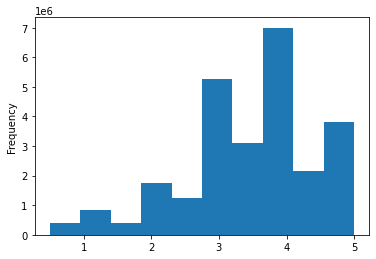

In [173]:
pd.options.display.float_format = '{:20,.2f}'.format
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()